# Set Up

In [1]:
# Reviews CSV (updated)
%%capture
!wget https://www.dropbox.com/scl/fi/6u1yfcnnf4jqmhedx519u/reviews.csv?rlkey=xqmvvohkq0i0k7hho79fs43b6&st=ko3q9dnq&dl=0
!mv reviews.csv?rlkey=xqmvvohkq0i0k7hho79fs43b6 reviews.csv

# Reviews images related
!wget https://www.dropbox.com/scl/fi/2o3fmzj4jdsfujfhu0mns/reviews.zip?rlkey=yc8doasvaavp2993huknxw6jt&st=3e3bpy5q&dl=0
!mv reviews.zip?rlkey=yc8doasvaavp2993huknxw6jt reviews.zip
!unzip reviews.zip
# Metadata for each restaurant
!wget https://www.dropbox.com/scl/fi/cxckzuj81gsnlsvclqnza/metadata.json.gz?rlkey=d4xerrcwbeyt09oi01f9f4wru&st=sv6cnpzh&dl=0
!mv metadata.json.gz?rlkey=d4xerrcwbeyt09oi01f9f4wru metadata.json.gz

!wget https://www.dropbox.com/scl/fi/50pmwvytozpz0cl1p054f/tiny_LLaVa_images_descriptions.json.gz?rlkey=7vreygmtd16lohs3bx6yvmwdk&st=9568qz84&dl=0
!mv tiny_LLaVa_images_descriptions.json.gz?rlkey=7vreygmtd16lohs3bx6yvmwdk tiny_LLaVa_images_descriptions.json.gz

!wget https://www.dropbox.com/scl/fi/g8862obe2z29su61popjx/restaurants.csv?rlkey=rhrn6vg0zg6ier2yuz9lh00yh&st=tqfdpqjv&dl=0
!mv restaurants.csv?rlkey=rhrn6vg0zg6ier2yuz9lh00yh restaurants.csv

# Libraries

In [1]:
%%capture
!pip install --upgrade -q accelerate bitsandbytes
!pip install accelerate
!pip install pyreclab
!pip install cornac
!pip install pali-torch
!pip install einops torchvision

import pandas as pd
import numpy as np
import json
import gzip
import pyreclab
import random
from sklearn.model_selection import train_test_split
import scipy.sparse as sparse
import os
# images
from keras.applications import vgg16, vgg19, ResNet50
from tensorflow.keras.utils import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
# text
import requests
import heapq
import math
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from io import BytesIO
import pickle
import time

# cornac
import cornac
from cornac.data import Reader, Dataset
import cornac.datasets
from cornac.eval_methods import RatioSplit
from cornac.data import TextModality, ImageModality
from cornac.data.text import BaseTokenizer
from cornac.models import PMF, SoRec, WMF, CTR, BPR, VBPR, DMRL, AMR
import torch

# SBert
from sentence_transformers import SentenceTransformer

from concurrent.futures import ThreadPoolExecutor

In [2]:
%%capture
!pip install lightFM --upgrade
from lightfm import LightFM
from lightfm.data import Dataset
import lightfm.evaluation as lightfm_eval

In [3]:
from lightfm.evaluation import auc_score

In [4]:
from transformers import AutoProcessor, LlavaForConditionalGeneration
from transformers import BitsAndBytesConfig
import torch


In [5]:
from tqdm import tqdm

In [6]:
from collections import Counter

In [7]:
from itertools import combinations

In [8]:
from scipy.sparse import csr_matrix

# Data Preprocessing

In [9]:
df = pd.read_csv('reviews.csv')
print(f"Tamaño dataset: {df.shape}")

count_per_state = df['state'].value_counts()
for state, count in count_per_state.items():
    folder_size = len(os.listdir(f'reviews/{state}'))
    print(f"State: {state}, Count: {count}")
    print(f"Folder size {folder_size}")
    if folder_size >= count:
        print('- Se encuentran todas las imagenes => No hay conflictos\n')
    else:
        print('- Hay que eliminar imagenes => Conflicto\n')
        for row in df.itertuples():
            img_filename = row.img_filename
            path = f'{row.gmap_id}.png'
            state = row.state
            if path not in os.listdir(f'reviews/{state}'):
                print(row)

# Eliminamos datos nulos ...
df = df.dropna()


Tamaño dataset: (8334, 9)
State: Virginia, Count: 2881
Folder size 2948
- Se encuentran todas las imagenes => No hay conflictos

State: California, Count: 1775
Folder size 1775
- Se encuentran todas las imagenes => No hay conflictos

State: Texas, Count: 1134
Folder size 1134
- Se encuentran todas las imagenes => No hay conflictos

State: Hawaii, Count: 984
Folder size 984
- Se encuentran todas las imagenes => No hay conflictos

State: Florida, Count: 912
Folder size 912
- Se encuentran todas las imagenes => No hay conflictos

State: North_Dakota, Count: 648
Folder size 678
- Se encuentran todas las imagenes => No hay conflictos



In [10]:
X = df[['user_id', 'rest_id', 'rating']]

In [11]:
restaurants = pd.read_csv('restaurants.csv')


categories = restaurants['categories'].unique()
categ2idx = {categ : idx for idx, categ in enumerate(categories)}
idx2categ = {idx : categ for categ, idx in categ2idx.items()}


restaurants_lst = list(restaurants.iterrows())


X_categories = []
for row in X.itertuples():
    rest_id = row.rest_id
    categ = restaurants_lst[rest_id][1].categories
    idx_categ = categ2idx[categ]
    X_categories.append(idx_categ)

X['categ_id'] = X_categories

<ipython-input-11-0a147b4e1a57>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['categ_id'] = X_categories


In [12]:
restaurants.index

RangeIndex(start=0, stop=7044, step=1)

In [13]:
X.head()

,user_id,rest_id,rating,categ_id
0,114453580163034019886,3818,5,0
1,103598690263545033047,3819,5,262
2,115640749244801394506,3820,5,8
3,104421748665385525393,3822,5,0
4,108976745273958544598,3823,4,143


In [14]:
# Obtenemos el json de la metadata
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield json.loads(l)

metadata = list(parse('metadata.json.gz'))
metadata = metadata[0]

In [15]:
metadata.keys()

dict_keys(['California', 'Florida', 'Hawaii', 'North_Dakota', 'Texas', 'Virginia'])

In [16]:
new_metadata = []
for value in metadata.values():
    new_metadata.extend(value)
idx2metadata = {}
for data in new_metadata:
    gmap_id = data['gmap_id']
    del data['gmap_id']
    idx2metadata[gmap_id] = data

In [17]:
categories = restaurants['categories'].unique()
categories2idx = {categ : idx for idx, categ in enumerate(categories)}
idx2categories = {idx : categ for categ, idx in categories2idx.items()}
restaurants_dict = restaurants.to_dict('index')
restaurant_categories = {k : categories2idx[v['categories']] for k, v in restaurants_dict.items() }

# Utils


In [18]:
# reciprocal rank
def rr(recommendation, review):
    review = list(map(int, review))
    recommendation = list(map(int, recommendation))
    for i, rec in enumerate(recommendation):
        if rec in review:
            return 1 / (i + 1)
    return 0

def recall(relevant_items, recommended_items): # Recall@K
    relevant_items = set(relevant_items)
    recommended_items = set(recommended_items)
    intersection = relevant_items.intersection(recommended_items)
    recall = len(intersection) / len(relevant_items) if len(relevant_items) > 0 else 0
    return recall

def precision(relevant_items, recommended_items): # Recall@K
    relevant_items = set(relevant_items)
    recommended_items = set(recommended_items)
    intersection = relevant_items.intersection(recommended_items)
    precision_value = len(intersection) / len(recommended_items) if len(relevant_items) > 0 else 0
    return precision_value


def precision_at_k(r, k):
    assert 1 <= k <= r.size
    return (np.asarray(r)[:k] != 0).mean()

def average_precision_at_k(r, k):
    r = np.asarray(r)
    score = 0.
    for i in range(min(k, r.size)):
        score += precision_at_k(r, i + 1)
    return score / k

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.

def idcg_at_k(k):
    return dcg_at_k(np.ones(k), k)

def ndcg_at_k(r, k, max_relevant):
    idcg = idcg_at_k(min(k, max_relevant))
    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

def diversity(reclists):
    diversity_value = 0
    num_users = len(reclists.keys())

    for user, recommended_rests in reclists.items():

        unique_categories = set()
        for rest_id in recommended_rests:
            categ_id = restaurant_categories[int(rest_id)]
            categ_names = idx2categories[categ_id]

            if categ_names == "Restaurant":
                continue
            else:
                unique_categories.add(categ_id)

        diversity_value += len(unique_categories) / len(recommended_rests)

    return diversity_value / num_users



def novelty(reclists):
    ''' Funcion que retorna la novedad promedio de un metodo sobre un dataset'''
    # x_train deberia estar ya definido ...
    popularity = Counter(list(map(lambda x: x[1], x_train)))
    total_interactions = len(x_train)
    rest_popularity = {k: v / total_interactions for k, v in popularity.items()}

    novelty_value = 0
    num_users = len(reclists.keys())

    for user, reclist in reclists.items():
        novelty_score = 0

        for rest_id in reclist:
            if rest_id not in rest_popularity.keys():
                novelty_score += np.log(1 / total_interactions)
            else:
                novelty_score += np.log(1 / rest_popularity[int(rest_id)])

        novelty_value += novelty_score / len(reclist)

    return novelty_value / num_users

def get_relevant_items(user):
    user_reviews = test_user_items[user]
    user_reviews = list(
        map(lambda x: x[0],
        filter(lambda x: x[1] >= 3.5, user_reviews)
    ))
    return user_reviews


def evaluate_model(model_reclist, n):
    mean_ap = 0.
    mean_ndcg = 0.
    mean_recall = 0.
    mean_precission = 0.
    mean_rr = 0.

    for u in test_user_items.keys():
        reclist = model_reclist[u]
        reclist = [int(x) for x in reclist]
        user_reviews = get_relevant_items(u)
        #user_reviews = test_users[u]


        rel_vector = [np.isin(user_reviews, reclist, assume_unique=True).astype(int)]


        mean_ap += average_precision_at_k(rel_vector, n)
        mean_ndcg += ndcg_at_k(rel_vector, n, len(user_reviews))

        mean_recall += recall(user_reviews, reclist)
        mean_precission += precision(user_reviews, reclist)
        mean_rr += rr(reclist, user_reviews)


    mean_ap /= len(test_users)
    mean_ndcg /= len(test_users)
    mean_recall /= len(test_users)
    mean_precission /= len(test_users)
    mean_rr /= len(test_users)

    novelty_value = novelty(model_reclist)
    diversity_value = diversity(model_reclist)

    print(f'MAP@{n}: {mean_ap}')
    print(f'nDCG@{n}: {mean_ndcg}')
    print(f'Recall@{n}: {mean_recall}')
    print(f'Precision@{n}: {mean_precission}')
    print(f'MRR@{n}: {mean_rr}')
    print(f'Novelty@{n}: {novelty_value}')
    print(f'Diversity@{n}: {diversity_value}')



In [271]:
def show_recommendations(user, reclist):
    rec_business_cols = {
        'name' : [],
        'description' : [],
        'categories': []

    }
    for rest_id in reclist:

        rec_business_cols['name'].append(restaurants_dict[rest_id]['name'])
        rec_business_cols['description'].append(restaurants_dict[rest_id]['descriptions'])
        rec_business_cols['categories'].append(restaurants_dict[rest_id]['categories'])


    reclist_df = pd.DataFrame(rec_business_cols)
    return reclist_df


# Models

## Multimodal Recssys (using LLaVa & all-MiniLM-L6-v2 )

In [ ]:
print(torch.cuda.is_available())

False


In [ ]:
# Importamos los modelos a usar
# LLaVa

model_id = "bczhou/tiny-llava-v1-hf"

processor = AutoProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(model_id, device_map="cpu")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/61.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/661M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

In [20]:
# all-MiniLM-L6-v2
encoder = SentenceTransformer("all-MiniLM-L6-v2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Generate Imgs Descriptions

In [ ]:
MAX_NEW_TOKENS = 30 # Maxima cantidad de tokens generados por LLaVa
PREFIX = 'reviews' # Carpeta donde se encuentran las imagenes.
# Generaremos el resumen de cada imagen usando LLaVa y luego con SBert
# obtenemos el embedding del texto

def get_description(img):
    message = "What's in the picture? Give me a brief summary"
    prompt = f"USER: <image>{message}\nASSISTANT:"

    input = processor(prompt, images=img, padding=True, return_tensors="pt").to("cuda")
    output = model.generate(**input, max_new_tokens=MAX_NEW_TOKENS)
    generated_text = processor.batch_decode(output, skip_special_tokens=True)
    description = generated_text[0].split("ASSISTANT: ")[-1]
    return description

def generate_embeddings(df):
    def process_row(row):
        path = f'{PREFIX}/{row.img_filename}'
        img = Image.open(path)
        description = get_description(img) # Generamos la descripcion de la imagen con LLaVa
        embedding = model.encode(description) # Generamos el embedding con all-MiniLM-L6-v2
        # Asociamos cada fila del dataframe el embedding asociado a la imagen.
        return embedding

    embeddings = []
    with ThreadPoolExecutor(max_workers=50) as executor:  # Ajusta max_workers según tu hardware
        results = list(tqdm(executor.map(process_row, [row for _, row in df.iterrows()]), total=df.shape[0]))

    return results

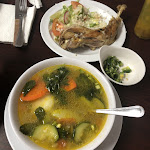

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
images = images = list(set(random.choices(os.listdir('reviews/California'), k=2)))
image = Image.open(f'reviews/California/{random.choice(images)}')
display(image)
get_description(image)

In [ ]:
images = [Image.open(f'reviews/{row.img_filename}').resize((128, 128)) for _, row in df.iterrows()]

In [ ]:
# Genera descripciones de imágenes en lotes y evita sobrecargar la GPU.
def batch_generate_descriptions(images):
    messages = ["What's in the picture? Give me a brief summary" for _ in images]
    prompts = [f"USER: <image>{message}\nASSISTANT:" for message in messages]

    inputs = processor(prompts, images=images, padding=True, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=MAX_NEW_TOKENS)
    generated_texts = processor.batch_decode(outputs, skip_special_tokens=True)

    descriptions = [text.split("ASSISTANT: ")[-1] for text in generated_texts]
    return descriptions


In [ ]:
def save_images_descriptions(df):
    img_description = {}
    batch_size = 16
    image_batch = []
    filenames = []

    for row in tqdm(df.itertuples(), total=len(df), desc="Processing rows"):
        img = Image.open(f'{PREFIX}/{row.img_filename}').resize((128, 128))
        image_batch.append(img)
        filenames.append(row.img_filename)

        # Procesamos el batch cuando alcanza el tamaño especificado ...
        if len(image_batch) == batch_size:
            descriptions = batch_generate_descriptions(image_batch)
            img_description.update({filenames[i]: descriptions[i] for i in range(len(filenames))})
            image_batch.clear()
            filenames.clear()
            torch.cuda.empty_cache()

    # procesamos las imgs restantes
    if image_batch:
        descriptions = batch_generate_descriptions(image_batch)
        img_description.update({filenames[i]: descriptions[i] for i in range(len(filenames))})
        torch.cuda.empty_cache()

    with gzip.open("images_descriptions.json.gz", 'wt', encoding='UTF-8') as zipfile:
        json.dump(img_description, zipfile)


In [ ]:
save_images_descriptions(df)

Processing rows: 100%|██████████| 8038/8038 [2:07:17<00:00,  1.05it/s]


## Download Imgs Descriptions

In [21]:
imgs_descriptions = list(parse("tiny_LLaVa_images_descriptions.json.gz"))[0]

In [22]:
imgs_embeddings = {}
# Generamos un embeddings de tamaño 384.
for key, value in tqdm(imgs_descriptions.items()):
    imgs_embeddings[key] = encoder.encode(value)


100%|██████████| 8038/8038 [04:20<00:00, 30.82it/s]


In [23]:
rev_embeddings = {}
for img_filename, emb in imgs_embeddings.items():
    gmap_id = img_filename.split("/")[-1].split(".")[0]
    rev_id = df[df['gmap_id'] == gmap_id].index[0]
    rev_embeddings[rev_id] = emb

In [24]:
rev_descriptions = {}
for img_filename, description in imgs_descriptions.items():
    gmap_id = img_filename.split("/")[-1].split(".")[0]
    rev_id = df[df['gmap_id'] == gmap_id].index[0]
    rev_descriptions[rev_id] = description



In [25]:
rev_id2info = X.to_dict('index')

In [26]:
user_reviews = {}
for r in X.itertuples():
    if not user_reviews.get(r.user_id):
        user_reviews[r.user_id] = []
    # (review ID, restaurant ID, review's rating, restaurant categories ID)
    user_reviews[r.user_id].append((r.Index, r.rest_id, r.rating, r.categ_id))

In [27]:
allreviews = np.array(list({ u : len(r) for u, r in user_reviews.items()}.values()))

In [28]:
print(len(user_reviews.keys()))

7254


In [29]:
print(allreviews.min())
print(allreviews.mean())
print(allreviews.max())

1
1.1080783016266886
10


In [30]:
count_reviews = Counter(allreviews)
for k, v in sorted(count_reviews.items(), key=lambda x: x[0]):
    print(f'{k:<2} {v:>5}')

1   6700
2    423
3     79
4     27
5     13
6      7
7      3
9      1
10     1


Por cada review de un usuario, creamos el set de train y el de test.
En el caso que un usuario tiene mas de una review, dejamos el 20% de las reviews para test y el resto para train (esto permite que el usuario tenga reviews tanto en testing como en training).
En el otro caso, si el usuario no tiene mas de 1 review, entonces lo dejamos para "entrenar el modelo", ya que no podriamos saber mas info.

In [31]:
train_set, test_set = [], []

for user, reviews in user_reviews.items():
    if len(reviews) <= 1:
        train_set.append(reviews)
    else:
        if 1 < len(reviews) <= 3:           # 2 o 3 reviews
            train_data, test_data = train_test_split(reviews, test_size=0.5, random_state=42)
        elif 3 < len(reviews) <= 5:         # 4 o 5 reviews
            train_data, test_data = train_test_split(reviews, test_size=0.6, random_state=42)
        else:                               # 6 o + reviews
            train_data, test_data = train_test_split(reviews, test_size=0.8, random_state=42)
        train_set.append(train_data)
        test_set.append(test_data)

In [32]:
x_train, x_test = [], []
for d in train_set:
    x_train.extend(d)
for d in test_set:
    x_test.extend(d)

> (review ID, restaurant ID, review's rating, restaurant categories ID)

In [33]:
print('Tamaño de Xtrain: ', len(x_train))
print('Tamaño de Xtest: ', len(x_test))

Tamaño de Xtrain:  7268
Tamaño de Xtest:  770


In [34]:
x_train[0]

(0, 3818, 5, 0)

In [35]:
train_embeddings = list(map(lambda x: rev_embeddings[x[0]], x_train))

In [36]:
test_users = {}
for x in x_test:
    rev_id = x[0]
    user_id = rev_id2info[rev_id]['user_id']
    if not test_users.get(user_id):
        test_users[user_id] = []
    test_users[user_id].append(rev_id)


In [37]:
train_users = {}
for x in x_train:
    rev_id = x[0]
    user_id = rev_id2info[rev_id]['user_id']

    if not train_users.get(user_id):
        train_users[user_id] = []

    train_users[user_id].append(rev_id)

In [38]:
# Usuario de testing y restaurantes evaluados
test_user_items = {}
for user, reviews in test_users.items():
    test_user_items[user] = [(rev_id2info[r]['rest_id'], rev_id2info[r]['rating']) for r in reviews]

# Usuario de training y restaurantes evaluados
train_user_items = {}
for user, reviews in train_users.items():
    train_user_items[user] = [(rev_id2info[r]['rest_id'], rev_id2info[r]['rating']) for r in reviews]

In [39]:
# Mapeamos desde una review a un restaurante
restid2revid = {v['rest_id']: k for k, v in rev_id2info.items()}

In [40]:
def get_restaurant_description(restid):
    '''Retorna una descripcion por default del restaurante en base a su metadata'''
    name = restaurants_dict[restid]['name']
    categories = restaurants_dict[restid]['categories']
    atmosphere = restaurants_dict[restid]['atmosphere']
    offerings = restaurants_dict[restid]['offerings']
    popularfor = restaurants_dict[restid]['popularFor']
    descriptions = restaurants_dict[restid]['descriptions']


    description = f'{name}. {categories}.'

    description += f'. {atmosphere}' if atmosphere is not np.nan else ''
    description += f'. {offerings}' if offerings is not np.nan else ''
    description += f'. {popularfor}' if popularfor is not np.nan else ''
    description += f'. {descriptions}' if descriptions is not np.nan else ''

    return description


Hay restaurantes que no tienen reseñas, como por ejemplo 3410. Asi que, para estos casos, utilizaremos su metadata.

In [41]:
get_restaurant_description(3410)

'The Rusty Rail Saloon, Inc. & Steak House. Bar;Steak house;Lunch restaurant.. Casual;Cozy. Alcohol;Hard liquor;Dancing;Food;Cocktails;Wine;Food at bar;Beer'

In [42]:
restaurants_embeddings = {}
for restid in restaurants_dict.keys():
    if not restid2revid.get(restid):
        embedding = encoder.encode(get_restaurant_description(restid))
    else:
        revid = restid2revid[restid]
        embedding = rev_embeddings[revid]

    if not restaurants_embeddings.get(restid):
        restaurants_embeddings[restid] = []
    restaurants_embeddings[restid].append(embedding)

In [43]:
for restid, embeddings in restaurants_embeddings.items():
    if len(embeddings) == 0:
        print(embeddings)

Para cada restaurante, obtenemos los embeddings relacionados a las reviews realizadas. Si tiene mas de una review, tomamos el promedio.

In [44]:
for restid, embeddings in restaurants_embeddings.items():
    if len(embeddings) == 1:
        restaurants_embeddings[restid] = np.array(embeddings[0])
    else:
        restaurants_embeddings[restid] = np.mean(embeddings, axis=0)

In [214]:
embedding_matrix = np.array([restaurants_embeddings[rest_id] for rest_id in restaurants_dict.keys()])

In [216]:
dataset = Dataset()
dataset.fit(
    users=train_users.keys(),
    items=restaurants_dict.keys(),
    item_features=[f"dim_{i}" for i in range(embedding_matrix.shape[1])]
)

In [217]:
item_features_data = [
    (rest_id, {f"dim_{i}": embedding[i] for i in range(len(embedding))})
    for rest_id, embedding in zip(restaurants_dict.keys(), embedding_matrix)
]
item_features = dataset.build_item_features(item_features_data, normalize=False)

In [218]:
flatmap_train_user_items = []
for user, reviews in train_user_items.items():
    for item, rating in reviews:
        flatmap_train_user_items.append((user, item, rating))

flatmap_test_user_items = []
for user, reviews in test_user_items.items():
    for item, rating in reviews:
        flatmap_test_user_items.append((user, item, rating))

In [220]:
train_interactions, _ = dataset.build_interactions(flatmap_train_user_items)
val_interactions, _ = dataset.build_interactions(flatmap_test_user_items)

In [223]:
num_users, num_items = train_interactions.shape
# mapeamos cada usuario segun la cantidad de items que tiene
scoring_user_ids = np.concatenate([np.full((num_items, ), i) for i in range(num_users)])
# mapeamos cada item repetidamente segun la cantidad de usaurios que lo tiene
scoring_item_ids = np.concatenate([np.arange(num_items) for i in range(num_users)])

user_mappings = dataset.mapping()[0] # diccionario mapeo relacion usuario item
item_mappings = dataset.mapping()[2] # diccionario mapeo relacion item usuario

inv_user_mappings = {value : key for key, value in user_mappings.items()}
inv_item_mappings = {value : key for key, value in item_mappings.items()}


## Model LightFM

In [224]:
LR = 0.05       # learning rate
N_COMP = 10     # N' de componentes
N_EPOCHS = 5   # Numero de epocas

### Analisis de sensibilidad

Componentes: 10, Learning Rate: 1e-05, AUC: 0.4979647994041443
Componentes: 10, Learning Rate: 0.0001, AUC: 0.4973823130130768
Componentes: 10, Learning Rate: 0.001, AUC: 0.4689466059207916
Componentes: 10, Learning Rate: 0.01, AUC: 0.47425276041030884
Componentes: 10, Learning Rate: 0.05, AUC: 0.5095901489257812
Componentes: 10, Learning Rate: 0.1, AUC: 0.49839651584625244
Componentes: 20, Learning Rate: 1e-05, AUC: 0.501289427280426
Componentes: 20, Learning Rate: 0.0001, AUC: 0.48089462518692017
Componentes: 20, Learning Rate: 0.001, AUC: 0.4398815333843231
Componentes: 20, Learning Rate: 0.01, AUC: 0.5160039067268372
Componentes: 20, Learning Rate: 0.05, AUC: 0.5091984868049622
Componentes: 20, Learning Rate: 0.1, AUC: 0.5063501000404358
Componentes: 30, Learning Rate: 1e-05, AUC: 0.5003865361213684
Componentes: 30, Learning Rate: 0.0001, AUC: 0.44958439469337463
Componentes: 30, Learning Rate: 0.001, AUC: 0.45413097739219666
Componentes: 30, Learning Rate: 0.01, AUC: 0.52523601055

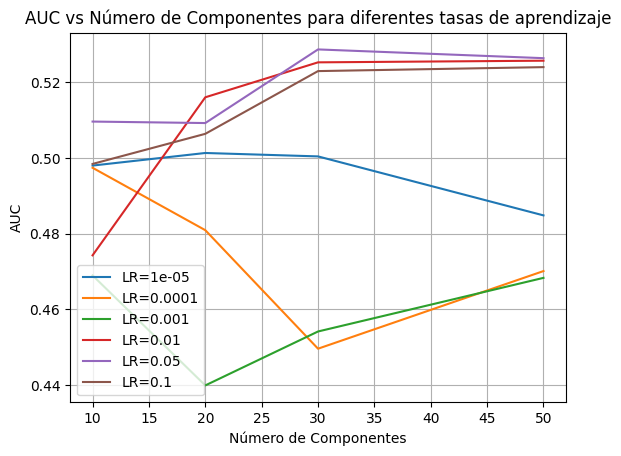

In [231]:
def fm_eval_n_comp():
    ncomp_values = [10, 20, 30, 50]
    learning_rate_values = [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1]
    results = []
    max_auc = -np.inf
    best_comp = None
    best_lr = None

    for n_comp in ncomp_values:
        for lr in learning_rate_values:
            model = LightFM(no_components=n_comp, learning_rate=lr, loss='warp')

            for epoch in range(N_EPOCHS):
                model.fit_partial(train_interactions, epochs=1, item_features=item_features)

            auc = auc_score(model, val_interactions, item_features=item_features).mean()
            print(f'Componentes: {n_comp}, Learning Rate: {lr}, AUC: {auc}')
            results.append((n_comp, lr, auc))

            if auc > max_auc:
                max_auc = auc
                best_comp = n_comp
                best_lr = lr

    print(f'\nMejor Componente: {best_comp}')
    print(f'Mejor Learning Rate: {best_lr}')
    print(f'Max AUC: {max_auc}')


    results = np.array(results)
    for lr in learning_rate_values:
        aucs_for_lr = results[results[:, 1] == lr][:, 2]
        plt.plot(ncomp_values, aucs_for_lr, label=f'LR={lr}')

    plt.xlabel('Número de Componentes')
    plt.ylabel('AUC')
    plt.title('AUC vs Número de Componentes para diferentes tasas de aprendizaje')
    plt.legend()
    plt.grid(True)
    plt.show()

    return results

results = fm_eval_n_comp()

In [233]:
best_n_comp = max(results, key=lambda x: x[2])[0]
best_lr = max(results, key=lambda x: x[2])[1]

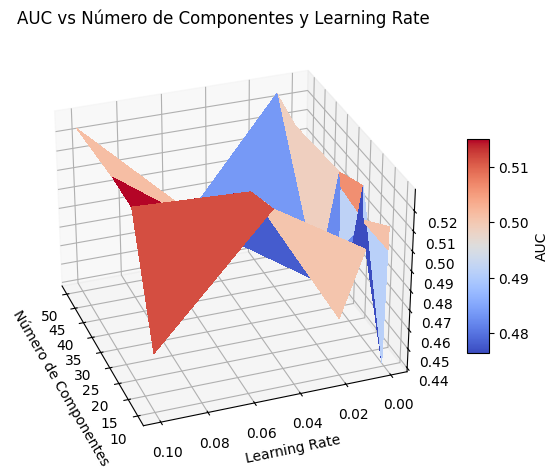

In [232]:
def gen_ses_analysis_3d(x_values, y_values, z_values, info):
    ''' Funcion que permite generar un grafico 3d de los parametros vs el valor
    generado. Por ejemplo: eje x: lambda; eje y: learning rate; eje z: RMSE. '''
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    X, Y = np.meshgrid(x_values, y_values)
    Z = np.array(z_values).reshape(len(y_values), len(x_values))

    surf = ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm,
                        linewidth=0, antialiased=False)

    ax.set_title(info['title'])
    ax.set_xlabel(info['x_label'])
    ax.set_ylabel(info['y_label'])
    ax.view_init(None, 160, 0)

    cbar = fig.colorbar(surf, shrink=0.5, aspect=10)
    cbar.set_label(info['z_label'])

    plt.tight_layout()
    plt.show()

sorted_n_comp = sorted(set(map(lambda x: x[0], results)))
sorted_lr = sorted(set(map(lambda x: x[1], results)))
auc_map = { (n_comp, lr) : auc for n_comp, lr, auc in results }
matrix_auc = np.zeros((len(sorted_n_comp), len(sorted_lr)))

for i, n_comp in enumerate(sorted_n_comp):
    for j, lr in enumerate(sorted_lr):
        if (n_comp, lr) in auc_map:
            matrix_auc[i, j] = auc_map[(n_comp, lr)]
        else:
            matrix_auc[i, j] = np.nan

gen_ses_analysis_3d(
    x_values=sorted_n_comp,
    y_values=sorted_lr,
    z_values=matrix_auc,
    info = {
        'title': 'AUC vs Número de Componentes y Learning Rate',
        'x_label': 'Número de Componentes',
        'y_label': 'Learning Rate',
        'z_label': 'AUC'
    },
)

### Entrenamiento

In [227]:
def fm_train(lr=LR, no_comp=N_COMP, epochs=N_EPOCHS, k=10):

    model_fm = LightFM(loss='warp')

    model_fm.fit(train_interactions, epochs=epochs, item_features=item_features, verbose=True)

    fm_reclist = {}
    for user_id in test_users.keys():
        scores = model_fm.predict(dataset.mapping()[0][user_id], np.arange(dataset.interactions_shape()[1]))
        top_10 = np.argsort(-scores)[:k]
        recommendations = np.array(list(restaurants_dict.keys()))[top_10]
        fm_reclist[user_id] = recommendations

    return fm_reclist


### Evaluation and examples

In [266]:
fm_reclist10 = fm_train(lr=best_lr, no_comp=best_n_comp, epochs=5, k=10)

Epoch: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


In [267]:
evaluate_model(fm_reclist10, n=10)

MAP@10: 0.0030685920577617335
nDCG@10: 0.025184670393572337
Recall@10: 0.024729241877256315
Precision@10: 0.0030685920577617335
MRR@10: 0.014033579737550853
Novelty@10: 6.715657384044507
Diversity@10: 0.9637184115523451


In [268]:
fm_reclist20 = fm_train(lr=best_lr, no_comp=best_n_comp, epochs=5, k=20)

Epoch: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


In [270]:
evaluate_model(fm_reclist20, n=20)

MAP@20: 0.0032490974729241897
nDCG@20: 0.04910108227248537
Recall@20: 0.04861612515042117
Precision@20: 0.0031588447653429622
MRR@20: 0.022067910608191812
Novelty@20: 7.222827519837184
Diversity@20: 0.8877256317689523


In [273]:
random_user = '100012107238749468669'
random_user_rec10 = fm_reclist10[random_user]
random_user_rec20 = fm_reclist20[random_user]

In [274]:
show_recommendations(user=random_user, reclist=random_user_rec10)

,name,description,categories
0,America's Bistro,NaN,Honduran restaurant;Venezuelan restaurant;Lati...
1,Banzai | Japanese Kitchen,NaN,Restaurant;Japanese restaurant
2,Kabob House Food Corner,NaN,Restaurant
3,Waffle House,Simple chain spot offering American diner fare...,Diner;Breakfast restaurant;Takeout Restaurant;...
4,Subway,Casual counter-serve chain for build-your-own ...,Caterer;Fast food restaurant;Takeout Restauran...
5,Pier 88,NaN,Seafood restaurant;Cajun restaurant
6,The Spot Lounge,NaN,Asian fusion restaurant;Restaurant;Korean rest...
7,Roll One For Mi,"Inventive sushi rolls, noodles & other Japanes...",Japanese restaurant;Sushi restaurant
8,Captain D's,"Fast, casual seafood restaurant chain serving ...",Fish & chips restaurant;American restaurant;Fa...
9,Ole Ole Mexican Grill and Cantina,NaN,Restaurant


In [275]:
show_recommendations(user=random_user, reclist=random_user_rec20)

,name,description,categories
0,Subway,Casual counter-serve chain for build-your-own ...,Caterer;Fast food restaurant;Takeout Restauran...
1,Sushi With Attitude,NaN,Sushi takeaway;Restaurant;Asian fusion restaurant
2,Five Boroughs Restaurant,NaN,Restaurant
3,Dixie's Cafe,NaN,American restaurant
4,Piola,NaN,Wine bar;Italian restaurant;Pizza delivery;Fam...
5,Tropical Twist,NaN,Cafe;Restaurant;Bakery
6,Luther Burger,NaN,Dessert shop;Breakfast restaurant;Coffee shop;...
7,Alejandro’s Mexican Food,NaN,Restaurant
8,Jade Gardens Chinese Restaurant,NaN,Chinese restaurant
9,Mimi's Peruvian Cuisine,Peruvian cuisine & desserts are offered in old...,Peruvian restaurant;Latin American restaurant;...


# Fuentes

- Kosse, R. (2023). Building a Recommender System with Text Embeddings using Python and LightFM. _Medium_. [link](https://medium.com/@r.kosse/building-a-embedding-recommender-system-with-python-and-lightfm-e18b3df16e88)